# E2E Image to Music Generation

* Class: CS236 - Deep Generative Models
* Project Name: E2E Image to Music Generation
* Approach: Pipeline two Pretrained Foundational Models (BLIP2, MusicGen-Large)
* Result: Tested on a single image
* Next Steps: Test on multiple images and with prompt variations

## Step 0
* Check assigned processors (A100 preferred with high RAM)
* Install Transformers, SciPy, Accelerate

In [ ]:
import numpy as np
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
weights_path = "/content/drive/MyDrive/jazz dataset/models_output/lm_epoch_24.pt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)


Mon Dec 11 00:15:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    41W / 300W |   4994MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --upgrade pip
!pip3 install -U xformers --index-url https://download.pytorch.org/whl/cu121
!pip install --upgrade transformers scipy
!pip install accelerate
!python3 -m pip install -U git+https://github.com/facebookresearch/audiocraft#egg=audiocraft
!pip install --upgrade torch
!pip install --upgrade torchaudio
!pip install --upgrade torchdata
!pip install --upgrade torchtext
!pip install --upgrade torchvision


Looking in indexes: https://download.pytorch.org/whl/cu121


## Step 1
* Configure and Load BLIP2 2.7B
* Extract Text Content from Image
* Store for pipeline

In [ ]:
# Load BLIP2 Model

import requests
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Load Test Image
img_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/A_Friend_in_Need_1903_C.M.Coolidge.jpg/220px-A_Friend_in_Need_1903_C.M.Coolidge.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
print(f"{raw_image=}")

# Process Image
inputs = processor(raw_image, return_tensors="pt")


raw_image=<PIL.Image.Image image mode=RGB size=220x158 at 0x7A3504847CD0>


In [ ]:
# Generate Text Output
out = model.generate(**inputs,max_new_tokens=50)
gen_text = processor.batch_decode(out, skip_special_tokens=True)
print(processor.decode(out[0], skip_special_tokens=True))

a painting of dogs playing poker on a table



## Step 2
* Load and Configure MusicGen-Large
* Prepare prompt and append generated text from BLIP2
* Convert Text to Music

In [ ]:
#from transformers import AutoProcessor, MusicgenForConditionalGeneration

# Load Model
# processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
# model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")

In [ ]:
# from audiocraft.models import MusicGen
from audiocraft.models import musicgen
from audiocraft.utils.notebook import display_audio
from transformers import AutoProcessor
import torch
processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
# model = MusicGen.get_pretrained("facebook/musicgen-small")
model = musicgen.MusicGen.get_pretrained('small', device='cuda')
model.set_generation_params(duration=8)

/usr/local/lib/python3.10/dist-packages/audiocraft/models/musicgen.py:116: UserWarning: MusicGen pretrained model relying on deprecated checkpoint mapping. Please use full pre-trained id instead: facebook/musicgen-small
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
# Process input text appending to the output of BLIP2
inp_text = 'Play 70s jazz music that goes with the mood in '
gen_str = str(gen_text)
gen_str = gen_str.replace("['", "")
gen_str = gen_str.replace("']", "")
inp_text += gen_str
print(inp_text)


Play 70s jazz music that goes with the mood in a painting of dogs playing poker on a table\n


In [ ]:
# Generate Music
inputs = processor(
    text = inp_text,
    padding = True,
    return_tensors = "pt",
)
# audio_values = model.generate(**inputs, progress = True, max_new_tokens = 512)

In [ ]:
# Alternative generation method; should work with the audiocraft version of the model
audio_values = model.generate(descriptions=[inp_text], progress = True)

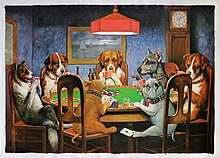

In [ ]:
import requests
from PIL import Image
from IPython.display import display
img_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/A_Friend_in_Need_1903_C.M.Coolidge.jpg/220px-A_Friend_in_Need_1903_C.M.Coolidge.jpg'
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
display(raw_image)

In [ ]:
# Play Generated Music from Image
from IPython.display import Audio
#from transformers import (
#    MusicgenConfig,
#    MusicgenDecoderConfig,
#    T5Config,
#    EncodecConfig,
#    MusicgenForConditionalGeneration,
#)
#model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small")

#sampling_rate = model.config.audio_encoder.sampling_rate
#Audio(audio_values[0].cpu().numpy(), rate=sampling_rate)
display_audio(audio_values, 32000)